In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg' # For mac users with Retina display

import numpy as np
import os
import random
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
from astropy import units as u
from read_cats import GetSDSSCat
import matplotlib.pyplot as plt
import cPickle as pickle
import gzip
import healpy as hp
from IPython.display import display, Math, Latex
from maps import Skymap, Healpixmap
from hpyroutines.utils import Sky2Hpx
from stackocat import QSOcat


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data_path = '/Users/fabbian/Work/quasar_stack/data/'

def GetCutout(pixmap, pixcent, npix):
    """
    Extracts a cutout of size (npix,npix) centered in (pixcent[0], pixcent[1]) from a bigger map pixmap
    """
    x, y = pixcent
    x, y = np.int(x), np.int(y)
    return pixmap[y-npix:y+npix+1, x-npix:x+npix+1]


In [2]:
ras = [
'01h26m11.96s',
'01h34m35.71s',
'01h49m46.16s',
'02h20m52.12s',
'02h48m58.81s',
'04h10m10.60s',
'05h33m58.44s',
'06h15m11.07s',
'07h57m25.07s',
'08h59m29.94s',
'11h36m34.31s',
'12h48m15.21s',
'16h03m57.39s',
'18h14m17.30s',
'18h35m33.71s',
'20h54m25.69s',
'22h01m23.39s',
'22h10m11.87s',
'22h16m19.09s',
'22h38m10.20s',
'22h46m07.57s',
'23h05m25.88s']

In [3]:
decs = [
'-05d29m09.6s',
'-29d22m45.4s',
'+23d50m14.6s',
'+01d37m11.6s',
'+27d05m29.8s',
'-09d13m05.2s',
'-34d01m34.5s',
'-57d16m14.6s',
'+51d13m19.7s',
'+48d23m02.3s',
'+42d36m02.6s',
'-21d54m20.4s',
'+27d45m53.3s',
'+34d12m25.0s',
'+43d55m49.1s',
'+02d07m11.0s',
'+02d26m21.8s',
'-35d07m20.0s',
'+07d23m54.5s',
'+26d53m19.8s',
'-05d26m35.0s',
'-00h39m25.7s',
]

In [5]:
c = SkyCoord(ras, decs)#, frame='icrs')

In [7]:
data_path = '/Volumes/LACIE_SHARE/Data/'

lambdas = [250, 350, 500]

# Cutouts (half-)size in pixels
npix    = {250:25, # SPIRE pixels are ~ 6  arcsec -> cutouts are 5'
           350:19, # SPIRE pixels are ~ 8  arcsec -> cutouts are 5'
           500:13} # SPIRE pixels are ~ 12 arcsec -> cutouts are 5'

# Beam @ different freq
psf     = {250:17.8, # in arcsec
           350:24.0, # in arcsec
           500:35.2} # in arcsec

factor  = {250:469./36.,   # Jy/beam -> Jy/pixel
           350:831./64.,   # Jy/beam -> Jy/pixel
           500:1804./144.} # Jy/beam -> Jy/pixel

# Pixel resolution
reso    = {250:6.,  # in arcsec
           350:8.,  # in arcsec
           500:12.} # in arcsec

positions = {250: (25.5, 25.5), 350: (19.5,19.5), 500:(13.5,13.5)}

# H-ATLAS patches
patches = ['G9', 'G12']#, 'G15']#, 'NGP', 'SGP']


In [33]:
# Loop over wavelengths ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
results = []

for lambda_ in [250]:
    print("...lambda : " + str(lambda_))
    # Loop over patches
    for patch in patches:
        print("\t...patch : " + patch)
        num = ''.join(x for x in patch if x.isdigit())

        # Fits files
        # fmap = data_path + 'H-ATLAS/' + patch + '/HATLAS_GAMA' + str(num) + '_DR1_BACKSUB' + str(lambda_) + '.FITS'
        fmap = data_path + 'H-ATLAS/' + patch + '/HATLAS_GAMA' + str(num) + '_DR1_FILT_BACKSUB' + str(lambda_) + '.FITS'
        fmask = data_path + 'H-ATLAS/' + patch + '/HATLAS_GAMA' + str(num) + '_DR1_MASK' + str(lambda_) + '.FITS'
        fnoise = data_path + 'H-ATLAS/' + patch + '/HATLAS_GAMA' + str(num) + '_DR1_SIGMA' + str(lambda_) + '.FITS'

        fluxmap = Skymap(fmap, psf[lambda_], fnoise=fnoise, fmask=fmask, color_correction=1.0)

        map_mean = np.mean(fluxmap.map[np.where(fluxmap.mask == 1.)])

        print("\t...the mean of the map is : %.5f Jy/beam" %(map_mean))

        # Remember that x refers to axis=0 and y refers to axis=1 -> MAP[y,x]
        x, y = fluxmap.w.wcs_world2pix(c.ra.deg, c.dec.deg, 0) # 0 because numpy arrays start from 0
        good_idx = (~np.isnan(x)) & (~np.isnan(y)) & (x >= 0) & (y >= 0) 
        x = x[good_idx]
        y = y[good_idx]
        print x, y

#         results = []
        
        for i in xrange(len(x)):
            cutmask = GetCutout(fluxmap.mask, (x[i],y[i]), npix=npix[lambda_])
            isgood = True if np.mean(cutmask) == 1 else False # Do analysis if all the cutout within the footprint

            if isgood: # Cutout is *completely* in the footprint
                results.append(GetCutout(fluxmap.map, (x[i],y[i]), npix=npix[lambda_]))
            else: # discard object
                pass


...lambda : 250
	...patch : G9
	...the mean of the map is : 0.00093 Jy/beam
[ 13914.2212949   4369.3978878] [ 45887.3891391   39910.43744443]
	...patch : G12
	...the mean of the map is : 0.00098 Jy/beam
[ 70314.30706538  40413.8397786    7875.78897192] [ 96310.26160134  59426.23540919  34272.95176043]


In [37]:
results

[]

In [40]:
X, Y = fluxmap.w.wcs_world2pix(c.ra.deg, c.dec.deg, 0) # 0 because numpy arrays start from 0


In [41]:
X

array([             nan,              nan,              nan,
                    nan,              nan,              nan,
                    nan,  627717.6149824 ,   70314.30706538,
         40413.8397786 ,    7875.78897192,   -2989.56532937,
        -55493.30089426,              nan,              nan,
                    nan,              nan,              nan,
                    nan,              nan,              nan,
                    nan])

In [91]:
mask = hp.read_map('/Users/fbianchini/Research/Data/herschel_contrast_zcut_1.5_10_ALL_gal_512.fits')
mask[mask > -2] = 1

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [59]:
mask[Sky2Hpx(c.ra.deg, c.dec.deg,512)] = 100

In [62]:
Sky2Hpx(c.ra.deg, c.dec.deg,512)

array([3018623, 3123313, 2520859, 2846118, 2330469, 2582652, 2359628,
       2296297,  763832,  542669,  111346,  543414,  411552,  982364,
       1004957, 2260253, 2573664, 2857728, 2563469, 2291197, 2831582,
       2928816])

In [77]:
def plot_mwd(RA,Dec,org=0,title='Mollweide projection', projection='mollweide'):
    ''' RA, Dec are arrays of the same length.
    RA takes values in [0,360), Dec in [-90,90],
    which represent angles in degrees.
    org is the origin of the plot, 0 or a multiple of 30 degrees in [0,360).
    title is the title of the figure.
    projection is the kind of projection: 'mollweide', 'aitoff', 'hammer', 'lambert'
    '''
    x = np.remainder(RA+360-org,360) # shift RA values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    x=-x    # reverse the scale: East to the left
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection=projection, axisbg ='LightCyan')
    ax.scatter(np.radians(x),np.radians(Dec))  # convert degrees to radians
    ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
    ax.set_title(title)
    ax.title.set_fontsize(15)
    ax.set_xlabel("RA")
    ax.xaxis.label.set_fontsize(12)
    ax.set_ylabel("Dec")
    ax.yaxis.label.set_fontsize(12)
    ax.grid(True)

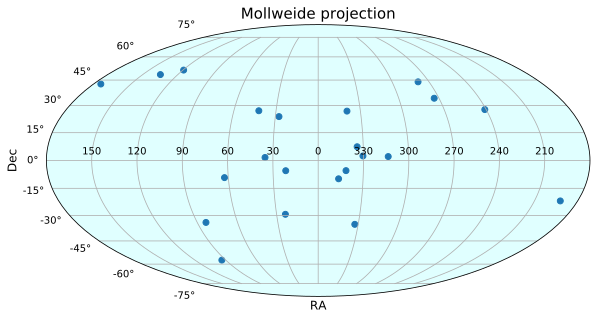

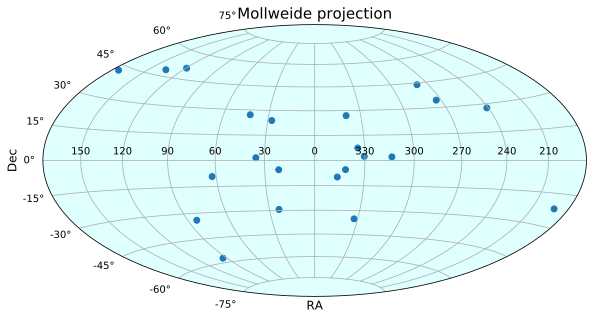

In [127]:
plot_mwd(c.ra.deg, c.dec.deg)
plot_mwd(c.ra.deg, c.dec.deg, projection='hammer')

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


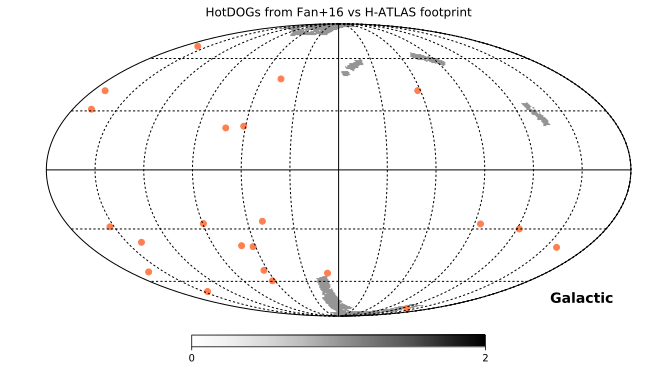

In [122]:
hp.mollview(mask, title="HotDOGs from Fan+16 vs H-ATLAS footprint", cmap='Greys', coord='G')
hp.graticule()    # add grid
hp.projscatter(c.galactic.l.deg, c.galactic.b.deg, lonlat=True, color='coral')#, coord='G')
plt.savefig('HotDogs_vs_H-ATLAS.pdf')

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


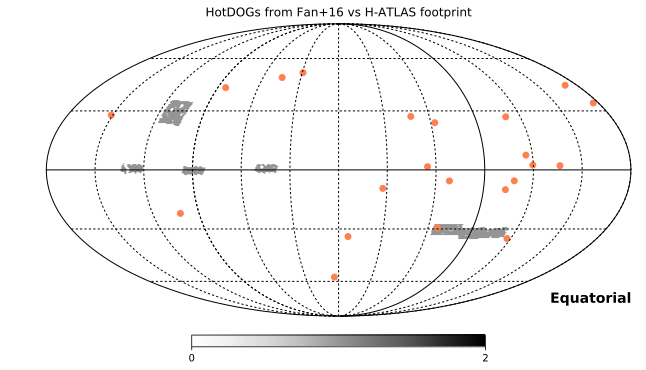

In [123]:
hp.mollview(mask, title="HotDOGs from Fan+16 vs H-ATLAS footprint", cmap='Greys', coord='GC', rot=90)
hp.graticule()    # add grid
hp.projscatter(c.ra.deg, c.dec.deg, lonlat=True, color='coral')#, coord='G')
plt.savefig('HotDogs_vs_H-ATLAS_eq.pdf')

In [128]:
from mpl_toolkits.basemap import Basemap


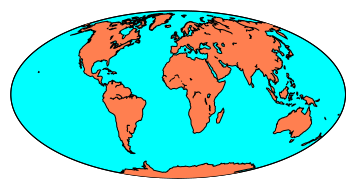

In [138]:
m = Basemap(projection='moll',lon_0=0,resolution='c')
m.drawcoastlines()
m.fillcontinents(color='coral',lake_color='aqua')
# # draw parallels and meridians.
# m.drawparallels(np.arange(-90.,120.,30.))
# m.drawmeridians(np.arange(0.,420.,60.))
m.drawmapboundary(fill_color='aqua')


In [160]:
1e6/60./24

694.4444444444445

In [164]:
75706.489207/3167

23.904796086832967

In [167]:
from astropy.coordinates import SkyCoord

In [170]:
bright_star = SkyCoord(342.02*u.degree, -3.5*u.degree, )
faint_star  = SkyCoord(332.02*u.degree, 0.5*u.degree,)


In [179]:
%timeit bright_star.separation(faint_star).deg

10 loops, best of 3: 21.3 ms per loop


In [180]:
def fn_ang_dist(ip_x1, ip_y1, ip_x2, ip_y2): #all numpy arrays

        # CONVERT INTO RADIANS
        x1 = np.radians(ip_x1)
        y1 = np.radians(ip_y1)
        x2 = np.radians(ip_x2)
        y2 = np.radians(ip_y2)

        ang_dist_rad = np.arccos(np.sin(y1)*np.sin(y2)+(np.cos(y1)*np.cos(y2)*np.cos(x1 - x2)))
        ang_dist_deg = np.degrees(ang_dist_rad) # Converting radians to degrees

        return ang_dist_deg * 3600

In [187]:
fn_ang_dist(342.02, -3.5, 332.02, 0.5)/3600.

10.765249973319754

In [185]:
bright_star.separation(faint_star).deg

10.765249973319788

In [214]:
1309/560.*34653

81001.3875

In [212]:
180/200.

0.9

## To reply to Andrea's email: how many of Fan+16 objects are in SDSS W4 detected?

In [4]:
qso_cat = QSOcat(GetSDSSCat(cats=['DR7', 'DR12'], discard_FIRST=True, z_DR12='Z_PIPE'), [(0.,10)], W4only=True, SN_W4=2)


	...z-bin : 0.0 < z < 10


In [5]:
qso_cat_full = QSOcat(GetSDSSCat(cats=['DR7', 'DR12'], discard_FIRST=True, z_DR12='Z_PIPE'), [(0.,10)],)


	...z-bin : 0.0 < z < 10


In [6]:
len(qso_cat.cat[0])

42157

In [7]:
c = SkyCoord(ras, decs)#, frame='icrs')

In [8]:
catalog = SkyCoord(ra=qso_cat.cat[0].RA*u.degree, dec=qso_cat.cat[0].DEC*u.degree)
catalog_full = SkyCoord(ra=qso_cat_full.cat[0].RA*u.degree, dec=qso_cat_full.cat[0].DEC*u.degree)

In [9]:
idx, d2d, d3d = catalog.match_to_catalog_sky(c)  

In [10]:
idx_full, d2d_full, d3d_full = catalog_full.match_to_catalog_sky(c)  

In [11]:
d2d[d2d <= 190.*u.arcsec]

<Angle [ 0.0001273] deg>

In [12]:
d2d_full[d2d_full <= 190.*u.arcsec]

<Angle [ 0.05027438, 0.0001273 , 0.05192824] deg>

In [13]:
out = np.where(d2d_full <= 2.*u.arcsec)[0]


In [14]:
myman = qso_cat_full.cat[0].iloc[out[0]]

In [15]:
myman

CC_FLAGS                            0000
DEC                              1.61976
ERR_FLUX02_12KEV                       0
ERR_FLUX02_2KEV                        0
ERR_FLUX2_12KEV                        0
ERR_HMAG                               0
ERR_JMAG                               0
ERR_KMAG                               0
ERR_W1MAG                          0.225
ERR_W2MAG                          0.253
ERR_W3MAG                          0.075
ERR_W4MAG                          0.092
ERR_ZPCA                              -1
ERR_ZPIPE                    0.000364757
EXTINCTION_G                    0.149105
EXTINCTION_I                   0.0820017
EXTINCTION_R                    0.108143
EXTINCTION_RECAL_G              0.126561
EXTINCTION_RECAL_I             0.0650622
EXTINCTION_RECAL_R             0.0875542
EXTINCTION_RECAL_U              0.162425
EXTINCTION_RECAL_Z             0.0483943
EXTINCTION_U                    0.202646
EXTINCTION_Z                   0.0581403
FIRSTMAG        

In [16]:
190./60

3.1666666666666665

In [17]:
from utils import WISEMag2mJy, SDSSMag2mJy, WmHz2mJy

In [18]:
W1 = WISEMag2mJy(myman.W1MAG, W='W1')
W2 = WISEMag2mJy(myman.W2MAG, W='W2')
W3 = WISEMag2mJy(myman.W3MAG, W='W3')
W4 = WISEMag2mJy(myman.W4MAG, W='W4')
err_W1 = WISEMag2mJy(myman.ERR_W1MAG, W='W1')
err_W2 = WISEMag2mJy(myman.ERR_W2MAG, W='W2')
err_W3 = WISEMag2mJy(myman.ERR_W3MAG, W='W3')
err_W4 = WISEMag2mJy(myman.ERR_W4MAG, W='W4')

In [19]:
err_W4 = WISEMag2mJy(myman.W4MAG-myman.ERR_W4MAG, W='W4') - WISEMag2mJy(myman.W4MAG+myman.ERR_W4MAG, W='W4')
err_W3 = WISEMag2mJy(myman.W3MAG-myman.ERR_W3MAG, W='W3') - WISEMag2mJy(myman.W3MAG+myman.ERR_W3MAG, W='W3')
err_W2 = WISEMag2mJy(myman.W2MAG-myman.ERR_W2MAG, W='W2') - WISEMag2mJy(myman.W2MAG+myman.ERR_W2MAG, W='W2')
err_W1 = WISEMag2mJy(myman.W1MAG-myman.ERR_W1MAG, W='W1') - WISEMag2mJy(myman.W1MAG+myman.ERR_W1MAG, W='W1')

In [20]:
y = myman.YFLUX * WmHz2mJy
j = myman.JFLUX * WmHz2mJy
h = myman.HFLUX * WmHz2mJy
k = myman.KFLUX * WmHz2mJy

err_y = myman.YFLUX_ERR * WmHz2mJy
err_j = myman.JFLUX_ERR * WmHz2mJy
err_h = myman.HFLUX_ERR * WmHz2mJy
err_k = myman.KFLUX_ERR * WmHz2mJy

In [21]:
h, err_h

(0.019264338788154332, 0.0059932456049767487)

In [22]:
uflux = SDSSMag2mJy(myman.PSFFLUX_U - myman.EXTINCTION_U)
gflux = SDSSMag2mJy(myman.PSFFLUX_G - myman.EXTINCTION_G)
rflux = SDSSMag2mJy(myman.PSFFLUX_R - myman.EXTINCTION_R)
iflux = SDSSMag2mJy(myman.PSFFLUX_I - myman.EXTINCTION_I)
zflux = SDSSMag2mJy(myman.PSFFLUX_Z - myman.EXTINCTION_Z)

erruflux = SDSSMag2mJy(1./myman.IVAR_PSFFLUX_U**0.5)
errgflux = SDSSMag2mJy(1./myman.IVAR_PSFFLUX_G**0.5)
errrflux = SDSSMag2mJy(1./myman.IVAR_PSFFLUX_R**0.5)
erriflux = SDSSMag2mJy(1./myman.IVAR_PSFFLUX_I**0.5)
errzflux = SDSSMag2mJy(1./myman.IVAR_PSFFLUX_Z**0.5)



In [23]:
SDSSMag2mJy(1./myman.IVAR_PSFFLUX_U**0.5)

0.00088926224209832786

In [24]:
print 'u  = %.5f ± %.5f mJy' %(uflux, erruflux)
print 'g  = %.5f ± %.5f mJy' %(gflux , errgflux)
print 'r  = %.5f ± %.5f mJy' %(rflux , errrflux)
print 'i  = %.5f ± %.5f mJy' %(iflux , erriflux)
print 'z  = %.5f ± %.5f mJy' %(zflux , errzflux)
print 'Y  = %.5f ± %.5f mJy' %(y,err_y)
print 'J  = %.5f ± %.5f mJy' %(j,err_j)
print 'H  = %.5f ± %.5f mJy' %(h,err_h)
print 'K  = %.5f ± %.5f mJy' %(k,err_k)
print 'W1 = %.5f ± %.5f mJy' %(W1,err_W1)
print 'W2 = %.5f ± %.5f mJy' %(W2,err_W2)
print 'W3 = %.5f ± %.5f mJy' %(W3,err_W3)
print 'W4 = %.5f ± %.5f mJy' %(W4,err_W4)


u  = 0.00062 ± 0.00089 mJy
g  = 0.00649 ± 0.00038 mJy
r  = 0.00637 ± 0.00052 mJy
i  = 0.00509 ± 0.00064 mJy
z  = 0.00707 ± 0.00224 mJy
Y  = 0.00457 ± 0.00375 mJy
J  = 0.00984 ± 0.00417 mJy
H  = 0.01926 ± 0.00599 mJy
K  = 0.02247 ± 0.00628 mJy
W1 = 0.02191 ± 0.00915 mJy
W2 = 0.04027 ± 0.01894 mJy
W3 = 1.97653 ± 0.27328 mJy
W4 = 12.35840 ± 2.09689 mJy


In [25]:
errrflux**0.5

0.022883592784551918

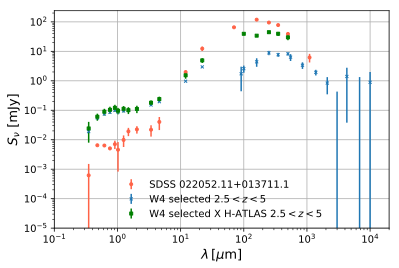

In [29]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.errorbar(3.4, W1, yerr=err_W1, fmt='o', color='tomato', ms=3, label='SDSS 022052.11+013711.1')
ax1.errorbar(4.6, W2, yerr=err_W2, fmt='o', color='tomato', ms=3)
ax1.errorbar(12,  W3, yerr=err_W3, fmt='o', color='tomato', ms=3)
ax1.errorbar(22,  W4, yerr=err_W4, fmt='o', color='tomato', ms=3)
ax1.errorbar(1.02, y, yerr=err_y, fmt='o', color='tomato',ms=3)#, label='UKIDSS')
ax1.errorbar(1.25, j, yerr=err_j, fmt='o', color='tomato',ms=3)
ax1.errorbar(1.49, h, yerr=err_h, fmt='o', color='tomato',ms=3)
ax1.errorbar(2.03, k, yerr=err_k, fmt='o', color='tomato',ms=3)
ax1.errorbar(0.35, uflux, yerr=erruflux, fmt='o', color='tomato',ms=3)#, label='SDSS')
ax1.errorbar(0.48, gflux, yerr=errgflux, fmt='o', color='tomato',ms=3)
ax1.errorbar(0.62, rflux, yerr=errrflux, fmt='o', color='tomato',ms=3)
ax1.errorbar(0.76, iflux, yerr=erriflux, fmt='o', color='tomato',ms=3)
ax1.errorbar(0.91, zflux, yerr=errzflux, fmt='o', color='tomato',ms=3)
ax1.errorbar(70,  65.4 , yerr= 3.6  , fmt='o',color='tomato',ms=3)
ax1.errorbar(160, 119  , yerr= 10.8, fmt='o',color='tomato',ms=3)
ax1.errorbar(250, 95    , yerr=5    , fmt='o',color='tomato',ms=3)
ax1.errorbar(350, 77.9 , yerr= 7    , fmt='o',color='tomato',ms=3)
ax1.errorbar(500, 39.  , yerr= 6.4 , fmt='o',color='tomato',ms=3)
ax1.errorbar(1100,6.2  , yerr= 2    , fmt='o',color='tomato',ms=3)
plt.errorbar(a[:,0],a[:,1],yerr=[a[:,2],a[:,3]], fmt='x', ms=3, label=r'W4 detected $2.5<z<5$')
plt.errorbar(b[:,0],b[:,1],yerr=[b[:,2],b[:,3]], fmt='s',color='g', ms=3, label=r'W4 detected X H-ATLAS $2.5<z<5$')
# plt.errorbar(lambdas,fluxes_mean,fmt='^',yerr=errs, color='g')#[err_flux_low,err_flux_hi])

ax1.set_xlabel(r'$\lambda \, [\mu$m]', size=13)
ax1.set_ylabel(r'$S_{\nu}$ [mJy]', size=13)
ax1.set_xscale('log')
ax1.set_yscale('log', nonposy='clip')
ax1.legend(loc='lower center', frameon=0)
# ax1.set_ylim([1e-5,3e1]) 
ax1.set_ylim(1e-5) 
ax1.set_xlim([1e-1,2e4]) 
plt.grid()
plt.savefig('Fan16_cross_match_SDSS_DR7_12_wHerschel.pdf')

In [7]:
a = np.loadtxt('SDSS_QSOs_W4selected_SNR2_stacked_fluxes_SPIRE_PACS_WISE_UKIDSS_SDSS_AKARI_PLANCK_CIBsub_2_NEW_zbin_2.5_5.0.dat')
b = np.loadtxt('SED_W4_selected_cross_match_HATLAS_cat_2.5_z_5.dat')
c = np.loadtxt('SED_W4_selected_W_over_r_100_cross_match_HATLAS_cat_2.5_z_5.dat')


In [36]:
lambdas = np.asarray([22, 12, 4.6, 3.4, 2.03, 1.49, 1.25, 1.02, 0.91, 0.76, 0.62, 0.48, 0.35, 70, 160, 250, 350, 500, 1100])


In [37]:
fluxes_mean = np.asarray([W4,W3,W2,W1,k,h,j,y,zflux,iflux,rflux,gflux,uflux,65.4, 119, 95, 77.9, 39., 6.2])


In [38]:
errs = np.asarray([err_W4,err_W3,err_W2,err_W1,err_k,err_h,err_j, err_y, errzflux,erriflux,errrflux,errgflux, errgflux,3.6,10.8,5,7,6.4,2])

In [89]:
err_flux_low = np.asarray([err_W4,err_W3,err_W2,err_W1,err_k,err_h,err_j, err_y, errzflux,erriflux,errrflux,errgflux, errgflux,3.6,10.8,5,7,6.4,2])

In [90]:
err_flux_hi = err_flux_low.copy()

(0.1, 20000.0)

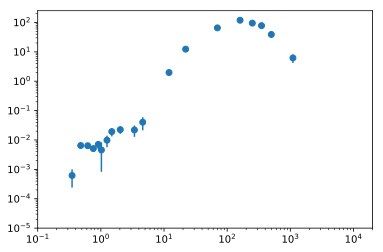

In [91]:
plt.errorbar(lambdas,fluxes_mean,fmt='o',yerr=errs)#yerr=[err_flux_low,err_flux_hi])
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-5) 
plt.xlim([1e-1,2e4]) 


In [39]:
np.savetxt('SED_SDSS_022052.11+013711.1.dat', np.c_[lambdas, fluxes_mean, errs, errs], header='SED of SDSS 022052.11+013711.1 \n columns are lambda [micron], flux [mJy]  1sigma_err_low [mJy] 1sigma_err_high [mJy]')

In [3]:
hd = np.loadtxt('SED_SDSS_022052.11+013711.1.dat')

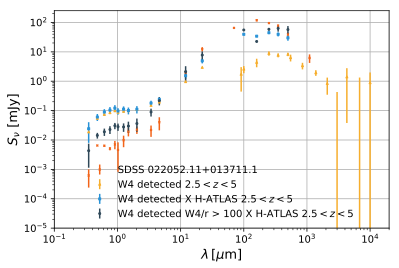

In [17]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
plt.errorbar(hd[:,0],hd[:,1],yerr=[hd[:,2],hd[:,3]], fmt='x', ms=2, color='#F26419', label=r'SDSS 022052.11+013711.1')
plt.errorbar(a[:,0],a[:,1],yerr=[a[:,2],a[:,3]], fmt='^',color='#F6AE2D', ms=2, label=r'W4 detected $2.5<z<5$')
plt.errorbar(b[:,0],b[:,1],yerr=[b[:,2],b[:,3]], fmt='s',color='#2892D7', ms=2, label=r'W4 detected X H-ATLAS $2.5<z<5$')
plt.errorbar(c[:,0],c[:,1],yerr=[c[:,2],c[:,3]], fmt='o',color='#2F4858', ms=2, label=r'W4 detected W4/r > 100 X H-ATLAS $2.5<z<5$')

ax1.set_xlabel(r'$\lambda \, [\mu$m]', size=13)
ax1.set_ylabel(r'$S_{\nu}$ [mJy]', size=13)
ax1.set_xscale('log')
ax1.set_yscale('log', nonposy='clip')
ax1.legend(loc='lower center', frameon=0)
# ax1.set_ylim([1e-5,3e1]) 
ax1.set_ylim(1e-5) 
ax1.set_xlim([1e-1,2e4]) 
plt.grid()
plt.savefig('money_plot.pdf')